In [3]:
import networkx as nx
import pandas as pd
import numpy as np
from scipy.stats import norm

In [4]:

class CausalGenerator:
    def __init__(self, graph, data,unit_vars,subunit_vars,sizes):
        self.graph = nx.DiGraph(graph)
        self.data = data
        self.processed_data = self.preprocess_data(unit_vars,subunit_vars,sizes)
        
    def preprocess_data(self,unit_vars,subunit_vars,sizes):
        # Aggregate subunit nodes
        data = {}
        
        for var in unit_vars:
            for i in range(len(sizes)):
                data[var+str(i)] = self.data[var+str(i)]
        for var in subunit_vars:
            for i in range(len(sizes)):
                s=0
                for j in range(sizes[i]):
                    s+=self.data['_'+var+str(i)+'_'+str(j)]
            data[var] = s/sizes[i]
        return data
    
    
    def generate(self, noise_dist, transition_funcs, sizes,special_node,intervention_value):
        generated = {}
        for node in nx.topological_sort(self.graph):
            if node is special_node:
                generated[node] = intervention_value
            else:
                for i in range(len(sizes)):
                    x=np.random.uniform()
                    parents = list(self.graph.predecessors(node))
                    if not parents:
                        generated[node+str(i)] = noise_dist[node](x)
                    else:
                        parent_values = [generated[p+str(i)] for p in parents]
                        generated[node+str(i)] = transition_funcs[node](*parent_values) + noise_dist[node](x)
        
        # Convert to pandas DataFrame
        return generated
        

In [5]:
import json

def load_data_from_json(file_path):
    """
    Load data from a JSON file and return it as a dictionary.
    
    :param file_path: Path to the JSON file
    :return: Dictionary containing the loaded data
    """
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
        print(f"Data successfully loaded from {file_path}")
        return data
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in {file_path}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")
        return None



In [6]:

# Example usage:
graph = [('a', '_b'), ('a', 'c'), ('_b', 'c'), ('c', '_d'), ('_b', '_d'), ('_d', 'e'), ('c', 'e')]
data = load_data_from_json('data/sampled_data.json')

unit_vars = ['a', 'c', 'e']
subunit_vars = ['d', 'b']
sizes = [50]*50

generator = CausalGenerator(graph, data,unit_vars,subunit_vars,sizes)
noise_dist = {
    'a': lambda x: norm.ppf(x),
    '_b': lambda x: norm.ppf(x, loc=0, scale=1),
    'c': lambda x: norm.ppf(x, loc=0, scale=1),
    '_d': lambda x: norm.ppf(x, loc=0, scale=1),
    'e': lambda x: norm.ppf(x, loc=0, scale=1)
}

transition_funcs = {
    '_b': lambda a: (a+1)**2,
    'c': lambda a, b: a**3 + (b+1)**2,
    '_d': lambda b, c: (b+1)**2 - c**3,
    'e': lambda c, d: c + (d+1)**2
}


Data successfully loaded from data/sampled_data.json


In [7]:

generated_data = generator.generate(noise_dist, transition_funcs,sizes,special_node='b',intervention_value=0)


In [8]:
print(generated_data)


{'a0': -2.4219142522777055, 'a1': 1.3225741308469323, 'a2': -0.4082053363302842, 'a3': -0.13317121142027902, 'a4': 0.11184705092021978, 'a5': 2.425500254836802, 'a6': 0.05943345673286837, 'a7': 1.7549789037751622, 'a8': -0.09830122042227968, 'a9': 0.6132114036808687, 'a10': 1.3887144193501761, 'a11': -1.4272531590289894, 'a12': 0.21246296568521839, 'a13': 0.6024468452778357, 'a14': -0.723428194135315, 'a15': -0.4686739328125545, 'a16': -0.2815851249024158, 'a17': 0.2712774786641819, 'a18': -0.531487601572311, 'a19': 1.207759921993823, 'a20': -0.6993124905031914, 'a21': 0.18998564275168323, 'a22': -1.0102497890987814, 'a23': 1.2491876894657772, 'a24': 1.0657263841383344, 'a25': 0.44598715141221407, 'a26': 0.4526913444615759, 'a27': -0.7480867154216699, 'a28': -1.3577447059490249, 'a29': -0.17595697236727362, 'a30': 1.0977144483790564, 'a31': 1.4318829952165262, 'a32': 0.38965501813261666, 'a33': 0.8583074973320012, 'a34': 1.40393952117303, 'a35': -1.2829648349210552, 'a36': 2.3478731646

In [9]:
# Generate arrays for each variable
a_array = [generated_data[f'a{k}'] for k in range(len(sizes))]
b_array = [generated_data[f'_b{k}'] for k in range(len(sizes))]
c_array = [generated_data[f'c{k}'] for k in range(len(sizes))]
d_array = [generated_data[f'_d{k}'] for k in range(len(sizes))]
e_array = [generated_data[f'e{k}'] for k in range(len(sizes))]

# Print the arrays
print("a arrays:", a_array)
print("b arrays:", b_array)
print("c arrays:", c_array)
print("d arrays:", d_array)
print("e arrays:", e_array)


a arrays: [-2.4219142522777055, 1.3225741308469323, -0.4082053363302842, -0.13317121142027902, 0.11184705092021978, 2.425500254836802, 0.05943345673286837, 1.7549789037751622, -0.09830122042227968, 0.6132114036808687, 1.3887144193501761, -1.4272531590289894, 0.21246296568521839, 0.6024468452778357, -0.723428194135315, -0.4686739328125545, -0.2815851249024158, 0.2712774786641819, -0.531487601572311, 1.207759921993823, -0.6993124905031914, 0.18998564275168323, -1.0102497890987814, 1.2491876894657772, 1.0657263841383344, 0.44598715141221407, 0.4526913444615759, -0.7480867154216699, -1.3577447059490249, -0.17595697236727362, 1.0977144483790564, 1.4318829952165262, 0.38965501813261666, 0.8583074973320012, 1.40393952117303, -1.2829648349210552, 2.3478731646473654, 0.6600252887454051, -0.8030874315297368, 0.8117410304454432, -0.652303468600695, 1.4702723468787569, -0.7408272326415425, 0.08016942172242783, -1.8219527248944334, 1.1687169700407654, 0.4398691573994478, -0.6853041175484785, -0.926

In [10]:
import numpy as np
from scipy.stats import gaussian_kde
from scipy.integrate import quad

In [11]:

def kl_divergence(p, q, bandwidth='scott'):
    """
    Calcule la divergence KL entre deux distributions empiriques représentées par des tableaux,
    en utilisant l'estimation de densité par noyau.
    
    :param p: Premier tableau de données
    :param q: Second tableau de données
    :param bandwidth: Méthode pour estimer la largeur de bande ('scott', 'silverman' ou un nombre)
    :return: Valeur de la divergence KL
    """
    # Assurez-vous que les tableaux ont la même taille
    min_len = min(len(p), len(q))
    p = p[:min_len]
    q = q[:min_len]
    
    # Estimation de densité par noyau
    kde_p = gaussian_kde(p, bw_method=bandwidth)
    kde_q = gaussian_kde(q, bw_method=bandwidth)
    
    # Créez un espace d'échantillonnage
    x = np.linspace(min(np.min(p), np.min(q)), max(np.max(p), np.max(q)), 10000)
    
    # Estimez les densités
    p_density = kde_p(x)
    q_density = kde_q(x)
    
    # Ajoutez un petit epsilon pour éviter la division par zéro
    epsilon = 1e-10
    p_density += epsilon
    q_density += epsilon
    
    # Normalisez les densités
    p_density /= np.sum(p_density)
    q_density /= np.sum(q_density)
    
    # Calculez la divergence KL
    return np.sum(p_density * np.log(p_density / q_density))



In [12]:

# Select two arrays for comparison
array1 = e_array  # First array from e_arrays
array2 = [data[f'e{i}'] for i in range(50)]  # Second array from the original data

arrayA = [data[f'a{i}'] for i in range(50)]  # Second array from the original data
arrayB = [np.mean(np.array([data[f'_b{i}_{j}'] for j in range(50)])) for i in range(50)]  # Second array from the original data
arrayC = [data[f'c{i}'] for i in range(50)]  # Second array from the original data




In [13]:

# Compute KL divergence
kl_div = kl_divergence(array1, array2)

# Print the KL divergence
print(f"KL divergence between the two arrays E: {kl_div}")
 # high kl div okay
 
kl_div = kl_divergence(arrayA, a_array)
print(f"KL divergence between the two arrays A: {kl_div}")

kl_div = kl_divergence(arrayB, b_array)
print(f"KL divergence between the two arrays B: {kl_div}")

kl_div = kl_divergence(arrayC, c_array)
print(f"KL divergence between the two arrays C: {kl_div}")

KL divergence between the two arrays: 0.29690745029328114
KL divergence between the two arrays A: 0.06540158865053852
KL divergence between the two arrays B: 0.10020648710483304
KL divergence between the two arrays C: 0.05849465052689237


/tmp/ipykernel_8785/526034867.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original, shade=True, color="blue", label="Original")
/tmp/ipykernel_8785/526034867.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(resampled, shade=True, color="red", label="Resampled")


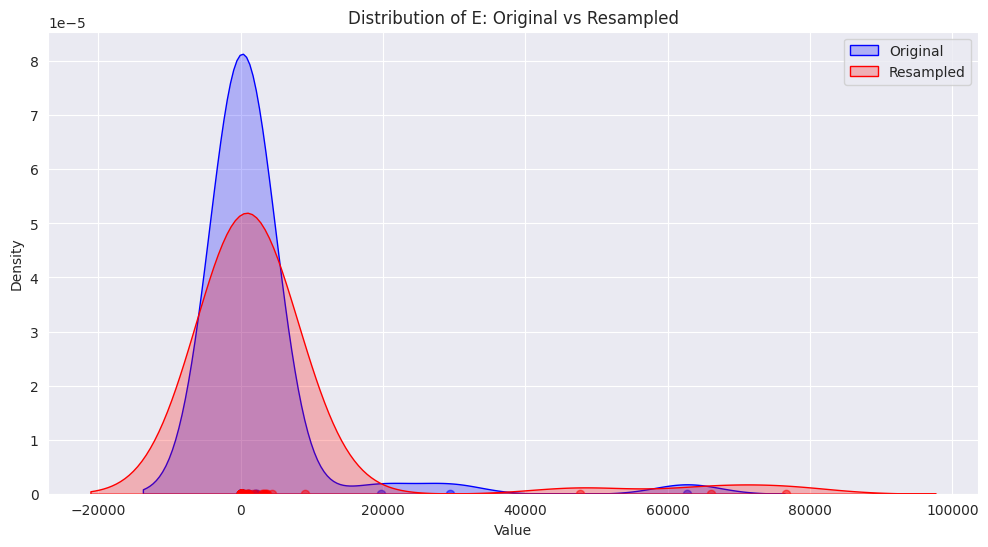

/tmp/ipykernel_8785/526034867.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original, shade=True, color="blue", label="Original")
/tmp/ipykernel_8785/526034867.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(resampled, shade=True, color="red", label="Resampled")


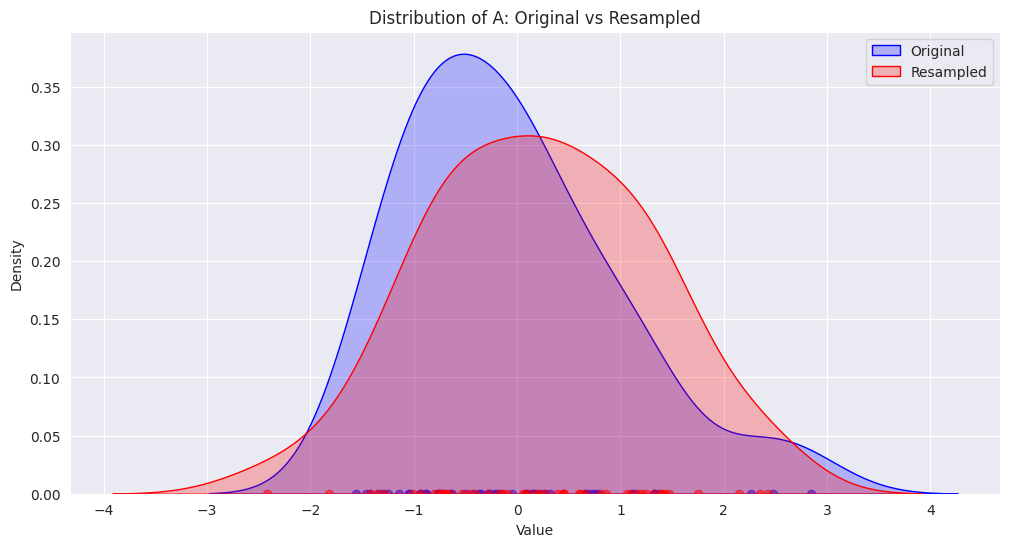

/tmp/ipykernel_8785/526034867.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original, shade=True, color="blue", label="Original")
/tmp/ipykernel_8785/526034867.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(resampled, shade=True, color="red", label="Resampled")


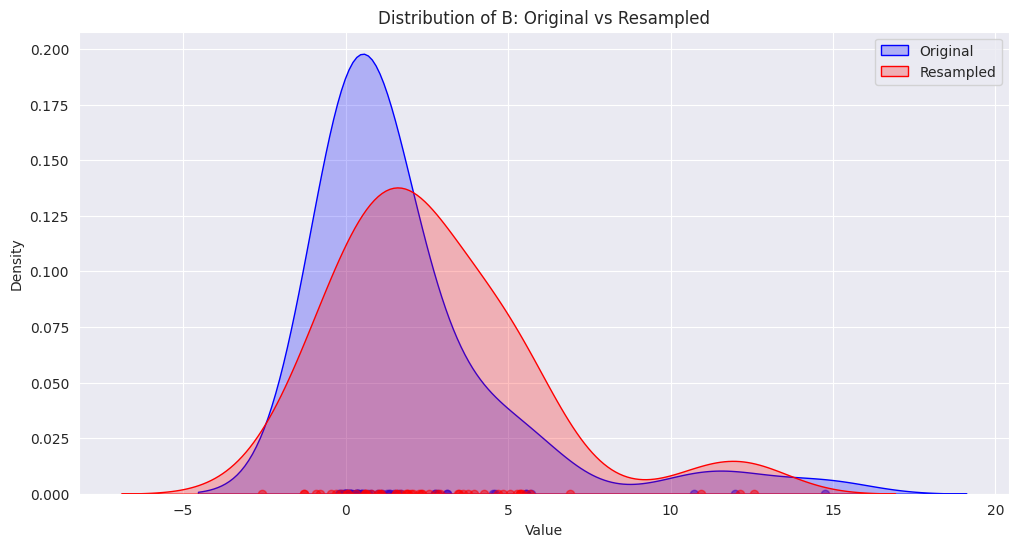

/tmp/ipykernel_8785/526034867.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original, shade=True, color="blue", label="Original")
/tmp/ipykernel_8785/526034867.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(resampled, shade=True, color="red", label="Resampled")


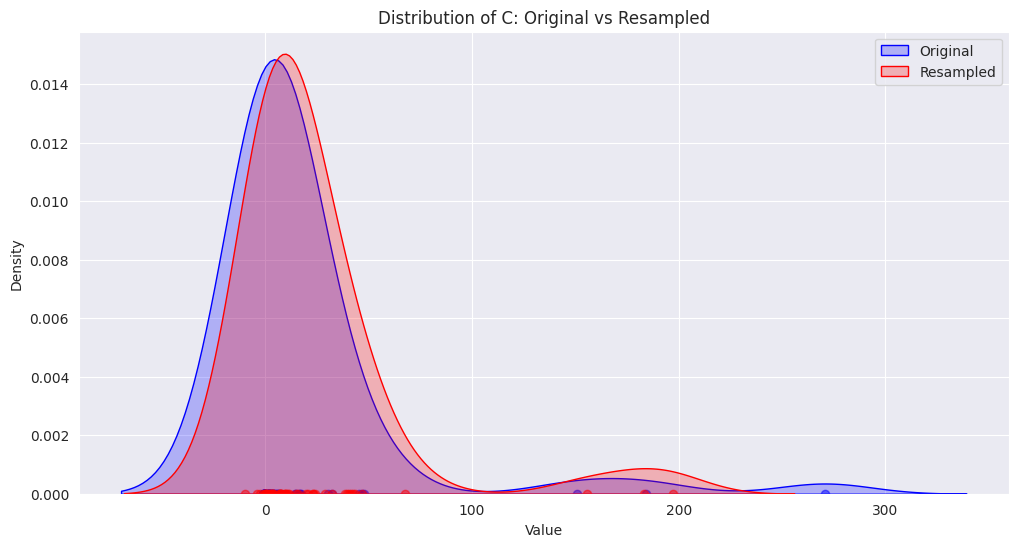

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_arrays_with_kde(original, resampled, title):
    plt.figure(figsize=(12, 6))
    
    # Plot original data
    sns.kdeplot(original, shade=True, color="blue", label="Original")
    plt.scatter(original, [0]*len(original), color="blue", alpha=0.5)
    
    # Plot resampled data
    sns.kdeplot(resampled, shade=True, color="red", label="Resampled")
    plt.scatter(resampled, [0]*len(resampled), color="red", alpha=0.5)
    
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Plot for E
plot_arrays_with_kde(array2, array1, "Distribution of E: Original vs Resampled")

# Plot for A
plot_arrays_with_kde(arrayA, a_array, "Distribution of A: Original vs Resampled")

# Plot for B
plot_arrays_with_kde(arrayB, b_array, "Distribution of B: Original vs Resampled")

# Plot for C
plot_arrays_with_kde(arrayC, c_array, "Distribution of C: Original vs Resampled")


In [30]:
def experiment(n):
    kldivs= []
    for k in range(n):
        # Example usage:
        graph = [('a', '_b'), ('a', 'c'), ('_b', 'c'), ('c', '_d'), ('_b', '_d'), ('_d', 'e'), ('c', 'e')]
        data = load_data_from_json(f'data/sampled_intervention_{k}.json')
        print(str(k) + " is in progress")
        
        unit_vars = ['a', 'c', 'e']
        subunit_vars = ['d', 'b']
        sizes = [50]*50
        
        generator = CausalGenerator(graph, data,unit_vars,subunit_vars,sizes)
        noise_dist = {
            'a': lambda x: norm.ppf(x),
            '_b': lambda x: norm.ppf(x, loc=0, scale=1),
            'c': lambda x: norm.ppf(x, loc=0, scale=1),
            '_d': lambda x: norm.ppf(x, loc=0, scale=1),
            'e': lambda x: norm.ppf(x, loc=0, scale=1)
        }
        
        transition_funcs = {
            '_b': lambda a: (a+1)**2,
            'c': lambda a, b: a**3 + (b+1)**2,
            '_d': lambda b, c: (b+1)**2 - c**3,
            'e': lambda c, d: c + (d+1)**2
        }
        
            
        generated_data = generator.generate(noise_dist, transition_funcs,sizes,special_node='b',intervention_value=0)
            # Generate arrays for each variable
        a_array = [generated_data[f'a{k}'] for k in range(len(sizes))]
        b_array = [generated_data[f'_b{k}'] for k in range(len(sizes))]
        c_array = [generated_data[f'c{k}'] for k in range(len(sizes))]
        d_array = [generated_data[f'_d{k}'] for k in range(len(sizes))]
        e_array = [generated_data[f'e{k}'] for k in range(len(sizes))]
            
            
        # Select two arrays for comparison
        array1 = e_array  # First array from e_arrays
        array2 = [data[f'e{i}'] for i in range(50)]  # Second array from the original data
        
        arrayA = [data[f'a{i}'] for i in range(50)]  # Second array from the original data
        arrayB = [np.mean(np.array([data[f'_b{i}_{j}'] for j in range(50)])) for i in range(50)]  # Second array from the original data
        arrayC = [data[f'c{i}'] for i in range(50)]  # Second array from the original data
        
        arrayD = [np.mean(np.array([data[f'_d{i}_{j}'] for j in range(50)])) for i in range(50)]  # Second array from the original data
        
        kldiv = {'c': kl_divergence(arrayC, c_array), 'b': kl_divergence(arrayB, b_array), 'a': kl_divergence(arrayA, a_array), 'd': kl_divergence(arrayD, d_array), 'e': kl_divergence(array2, array1)}
        
        
        kldivs.append(kldiv)
        
    return kldivs





    

In [31]:
kldivs = experiment(100)

Data successfully loaded from data/sampled_intervention_0.json
0 is in progress
Data successfully loaded from data/sampled_intervention_1.json
1 is in progress
Data successfully loaded from data/sampled_intervention_2.json
2 is in progress
Data successfully loaded from data/sampled_intervention_3.json
3 is in progress
Data successfully loaded from data/sampled_intervention_4.json
4 is in progress
Data successfully loaded from data/sampled_intervention_5.json
5 is in progress
Data successfully loaded from data/sampled_intervention_6.json
6 is in progress
Data successfully loaded from data/sampled_intervention_7.json
7 is in progress
Data successfully loaded from data/sampled_intervention_8.json
8 is in progress
Data successfully loaded from data/sampled_intervention_9.json
9 is in progress
Data successfully loaded from data/sampled_intervention_10.json
10 is in progress
Data successfully loaded from data/sampled_intervention_11.json
11 is in progress
Data successfully loaded from data/s

/tmp/ipykernel_8785/1427379182.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(kl_values, ax=axes[i], shade=True, color='skyblue')
/tmp/ipykernel_8785/1427379182.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(kl_values, ax=axes[i], shade=True, color='skyblue')
/tmp/ipykernel_8785/1427379182.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(kl_values, ax=axes[i], shade=True, color='skyblue')
/tmp/ipykernel_8785/1427379182.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(kl_values, a

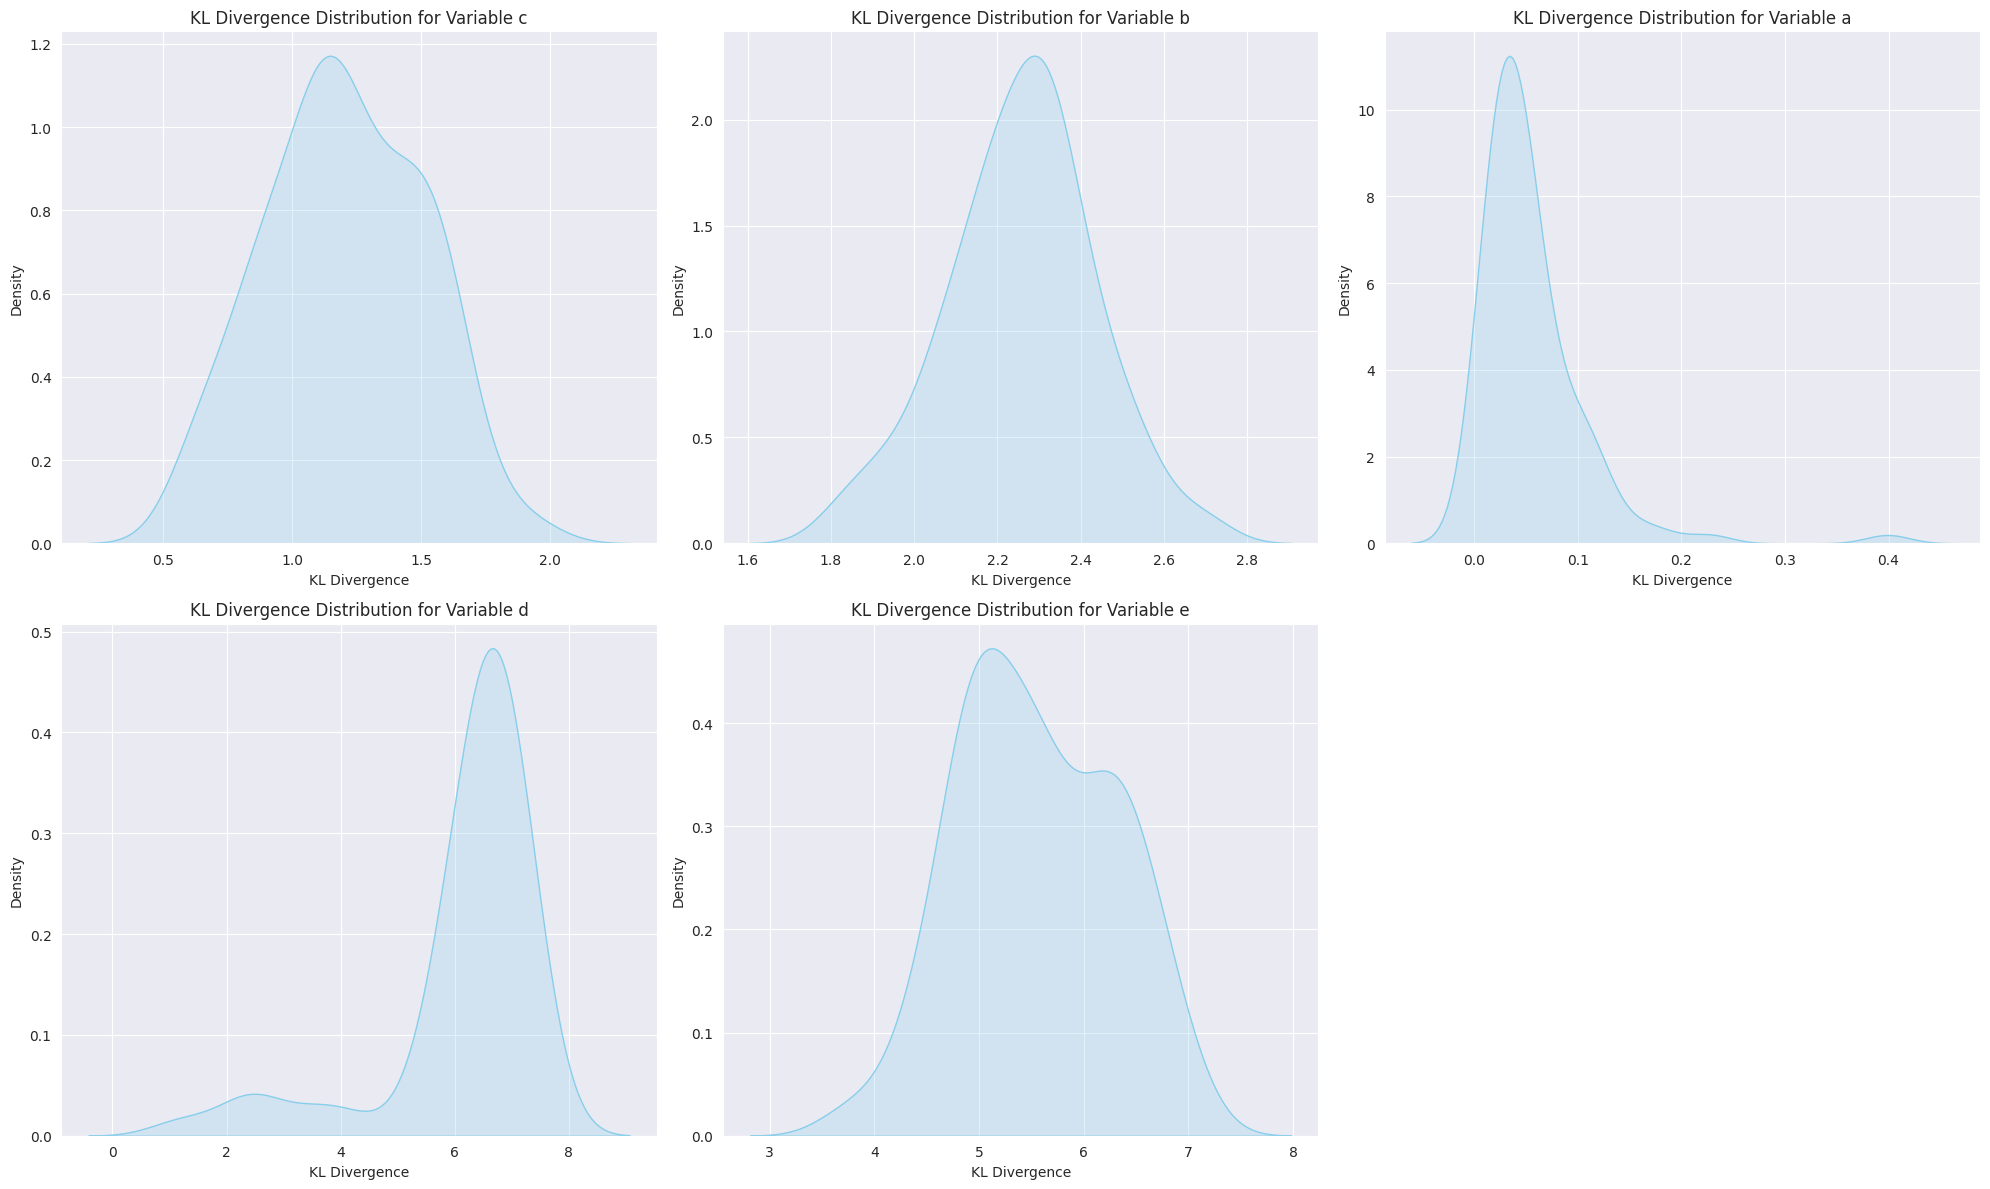

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
variables = list(kldivs[0].keys())  # Assuming kldivs is a list of dictionaries

# Create subplots for each variable
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, var in enumerate(variables):
    # Extract KL divergence values for the current variable
    kl_values = [kldiv[var] for kldiv in kldivs]
    
    # Create a KDE plot for the current variable
    sns.kdeplot(kl_values, ax=axes[i], shade=True, color='skyblue')
    
    # Customize the subplot
    axes[i].set_title(f'KL Divergence Distribution for Variable {var}')
    axes[i].set_xlabel('KL Divergence')
    axes[i].set_ylabel('Density')

# Remove the empty subplot
fig.delaxes(axes[5])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [33]:
import numpy as np

# Calculate mean and standard deviation for each variable
for var in variables:
    kl_values = [kldiv[var] for kldiv in kldivs]
    mean = np.mean(kl_values)
    std = np.std(kl_values)
    print(f"Variable {var}:")
    print(f"  Mean KL Divergence: {mean:.4f}")
    print(f"  Standard Deviation: {std:.4f}")
    print()


Variable c:
  Mean KL Divergence: 1.2013
  Standard Deviation: 0.3007

Variable b:
  Mean KL Divergence: 2.2553
  Standard Deviation: 0.1762

Variable a:
  Mean KL Divergence: 0.0551
  Standard Deviation: 0.0525

Variable d:
  Mean KL Divergence: 6.1417
  Standard Deviation: 1.3617

Variable e:
  Mean KL Divergence: 5.5476
  Standard Deviation: 0.7449

